<a href="https://colab.research.google.com/github/JoDeMiro/PythonCollabExamples/blob/main/Numba_Tutorial_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://youtu.be/x58W9A2lnQc

In [ ]:
%%html

<img src="https://upload.wikimedia.org/wikipedia/commons/f/fa/Spring-mass_under-damped.gif" align="center">

In [ ]:
import numpy as np
from pylab import *

In [ ]:
# Let's mix wet friction with dry friction, this makes the behavior
# of the system dependent on the initial condition, something
# may be interesting to study by running an exhaustive simulation

In [ ]:
def friction_fn(v, vt):
  if v > vt:
    return -v * 3
  else:
    return -vt * 3 * np.sign(v)

In [ ]:
def simulate_spring_mass_funky_damper(x0, T=10, dt=0.0001, vt=1.0):
  times = np.arange(0, T, dt)
  positions = np.zeros_like(times)

  v = 0
  a = 0
  x = x0
  positions[0] = x0/x0

  for ii in range(len(times)):
    if ii == 0:
      continue
    t = times[ii]
    a = friction_fn(v, vt) - 100 * x
    v = v + a*dt
    x = x + v*dt
    positions[ii] = x/x0

  return times, positions

In [ ]:
%time _ = simulate_spring_mass_funky_damper(1)

CPU times: user 486 ms, sys: 3.3 ms, total: 490 ms
Wall time: 499 ms


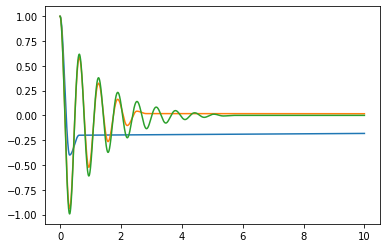

In [ ]:
plot(*simulate_spring_mass_funky_damper(0.1))
plot(*simulate_spring_mass_funky_damper(1))
plot(*simulate_spring_mass_funky_damper(10))

In [ ]:
# yout need to: simulate this system for initial conditions going from 0 to 10000 at 0.1 increments
# and then do some statistics on it...

In [ ]:
# mivel ez kurva sok időt venne igénybe ezért fel kell gyorsítanunk az időt, de hogyan?
# írjuk át függvényeket

In [ ]:
from numba import jit, njit, vectorize

In [ ]:
@njit
def friction_fn_jited(v, vt):
  if v > vt:
    return -v * 3
  else:
    return -vt * 3 * np.sign(v)

In [ ]:
@njit
def simulate_spring_mass_funky_damper_jited(x0, T=10, dt=0.0001, vt=1.0):
  times = np.arange(0, T, dt)
  positions = np.zeros_like(times)

  v = 0
  a = 0
  x = x0
  positions[0] = x0/x0

  for ii in range(len(times)):
    if ii == 0:
      continue
    t = times[ii]
    a = friction_fn_jited(v, vt) - 100 * x
    v = v + a*dt
    x = x + v*dt
    positions[ii] = x/x0

  return times, positions

In [ ]:
%time _ = simulate_spring_mass_funky_damper_jited(1)

CPU times: user 1.37 ms, sys: 0 ns, total: 1.37 ms
Wall time: 1.38 ms


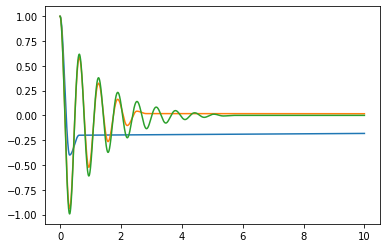

In [ ]:
plot(*simulate_spring_mass_funky_damper_jited(0.1))
plot(*simulate_spring_mass_funky_damper_jited(1))
plot(*simulate_spring_mass_funky_damper_jited(10))

In [ ]:
# Most jön az, hogy több szálon kezdjük el használni az amúgy is felgyorsított kódunkat

In [ ]:
from concurrent.futures import ThreadPoolExecutor

In [ ]:
@njit(nogil=True)
def friction_fn_jited_no_gil(v, vt):
  if v > vt:
    return -v * 3
  else:
    return -vt * 3 * np.sign(v)

In [ ]:
@njit(nogil=True)
def simulate_spring_mass_funky_damper_jited_no_gil(x0, T=10, dt=0.0001, vt=1.0):
  times = np.arange(0, T, dt)
  positions = np.zeros_like(times)

  v = 0
  a = 0
  x = x0
  positions[0] = x0/x0

  for ii in range(len(times)):
    if ii == 0:
      continue
    t = times[ii]
    a = friction_fn_jited_no_gil(v, vt) - 100 * x
    v = v + a*dt
    x = x + v*dt
    positions[ii] = x/x0

  return times, positions

In [ ]:
%time _ = simulate_spring_mass_funky_damper_jited_no_gil(1)

CPU times: user 1.34 ms, sys: 1.02 ms, total: 2.36 ms
Wall time: 3.92 ms


In [ ]:
# régi

In [ ]:
%%time

with ThreadPoolExecutor(8) as executor:
  executor.map(simulate_spring_mass_funky_damper_jited, np.arange(0.1, 1000))

CPU times: user 1.19 s, sys: 118 ms, total: 1.3 s
Wall time: 1.32 s


In [ ]:
# új

In [ ]:
%%time

with ThreadPoolExecutor(8) as executor:
  executor.map(simulate_spring_mass_funky_damper_jited_no_gil, np.arange(0.1, 1000))

CPU times: user 1.38 s, sys: 192 ms, total: 1.57 s
Wall time: 928 ms


In [ ]:
# van egy harmadik módja is a párhuzamosításnak amit a numba kínál és nem a ThreadExecutor

In [ ]:
from numba import prange

@njit(parallel=True)
def run_simulation(end=1000):
  for ii in prange(int(end/0.1)):
    if ii == 0:
      continue
    simulate_spring_mass_funky_damper_jited_no_gil(ii*0.1)

run_simulation(10) # just test if it's working

In [ ]:
%time run_simulation(1000)

CPU times: user 1.09 s, sys: 39 ms, total: 1.13 s
Wall time: 586 ms
